# Определение перспективного тарифа для телеком-компании
<font color='DarkBlue'> <br>
📌 Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент должен иметь информацию о том, какой тариф прибыльнее <br>
📌 Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов, их поведение и определить наиболее выгодный для компании тариф. В наличии данные 500 пользователей «Мегалайна» за 2018 год <br>
</font> 

## Изучение данных и предварительная обработка

In [1]:
# Импорт библиотеки pandas
import pandas as pd
# Импорт библиотеки numpy
import numpy as np
# Импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# Импорт библиотеки seaborn
import seaborn as sns
# Импорт библиотеки math
import math
# Импорт библиотеки scipy
from scipy.stats import norm
import scipy.stats
# Удаление ложных предупреждений
pd.options.mode.chained_assignment = None  # default='warn'
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

<font color='DarkBlue'> 
📌 Импортированы все библиотеки, используемые далее в проекте, и скорректированы настройки <br>
</font> 

### Датасет 'calls'

In [2]:
# Загрузка таблицы в память переменной df_calls типа dataframe
df_calls = pd.read_csv('/datasets/calls.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df_calls.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df_calls.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df_calls.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df_calls.head())
print('Количество явных дубликатов',df_calls.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
 ----- Информация о заголовках полей dataframe ----- 
Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
id            object
call_date     object
duration     float64
user_id        int64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных таблицы 'calls' сделаны следующие выводы:
    
1. Все заголовки выведены в удобном для работы с ними формате, редактирование не требуется
2. Отсутствуют пропуски и явные дубликаты
3. Тип данных поля 'call_date' необходимо преобразовать. Часть данных строкового поля 'id' скорее всего повторяет значение поля 'user_id'. Можно проверить, определив количество несовпадающих значений в данных указанного предположения
4. Среди данных присутствуют значения c нулевой продолжительностью звонков, возможно, это ошибка
</font> 

In [3]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
print('Количество несовпадающих значений идентификаторов пользователей в полях \'id\' и \'user_id\'',df_calls[df_calls['id'].apply(lambda x: x.split('_')[0]).astype('int') != df_calls['user_id']]['user_id'].count())

Количество несовпадающих значений идентификаторов пользователей в полях 'id' и 'user_id' 0


<font color='DarkBlue'> 
📌 Так как рассматриваемые значения идентификаторов пользователей полностью дублируются, можно убрать первую часть записи поля 'id' и уже преобразовать тип данных в более легковесный по объему занимаемой памяти целочисленный <br>
📌 Так же можно проверить типы данных датафрейма после их преобразований, вывести его на экран проверить корректность данных <br>    
</font> 

In [4]:
df_calls['id'] = df_calls['id'].apply(lambda x: x.split('_')[1]).astype('int')
display(df_calls.head())
print(df_calls.dtypes)

,id,call_date,duration,user_id
0,0,2018-07-25,0.00,1000
1,1,2018-08-17,0.00,1000
2,2,2018-06-11,2.85,1000
3,3,2018-09-21,13.80,1000
4,4,2018-12-15,5.18,1000


id                    int64
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object


<font color='DarkBlue'> 
📌 Теперь нужно проанализировать основные свойства значений полей <br>  
</font> 

In [5]:
display(df_calls.describe())
for i in df_calls.select_dtypes(include=['object','bool','datetime']):
    print('-----')
    display(df_calls[i].describe(datetime_is_numeric=True))
    if df_calls[i].count() != len(df_calls[i].unique()):
        print(df_calls[i].value_counts())
    else:
        print('Все значения уникальны')

,id,duration,user_id
count,202607.000000,202607.000000,202607.000000
mean,308.577181,6.755887,1253.940619
std,259.948786,5.843365,144.722751
min,0.000000,0.000000,1000.000000
25%,108.000000,1.300000,1126.000000
50%,243.000000,6.000000,1260.000000
75%,446.000000,10.700000,1379.000000
max,1759.000000,38.000000,1499.000000


-----


count                           202607
mean     2018-09-02 20:01:37.583992832
min                2018-01-01 00:00:00
25%                2018-07-05 00:00:00
50%                2018-09-17 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: call_date, dtype: object

2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
              ... 
2018-01-05      20
2018-01-07      18
2018-01-02       9
2018-01-03       7
2018-01-01       5
Name: call_date, Length: 365, dtype: int64


<font color='DarkBlue'> 
📌 В данных таблицы некорректные значения не наблюдаются, за исключением записей с нулевой продолжительностью звонков. Нужно уточнить количество подобных записей. В случае обнаружения большого количества строк с подобной аномалией удалять их будет не желательно <br> 
📌 Количество записей с информацией о совершенных звонках рассматриваемыми пользователями постоянно увеличивается ближе к концу года <br> 
📌 В среднем по 244 записи с данными по каждому пользователю <br>     
</font> 

In [6]:
print('Количество звонков с нулевой продолжительностью',df_calls[df_calls['duration'] == 0]['duration'].count())

Количество звонков с нулевой продолжительностью 39613


<font color='DarkBlue'> 
📌 Количество записей с нулевой продолжительностью звонков достаточно большое, но пропущенных звонков меньше осуществленных. Скорее всего нулями обозначены пропущенные звонки, поэтому их не нужно удалять. Также можно добавить дополнительный столбец, свидетельствующий о наличии факта осущетвленного звонка <br> 
</font> 

In [7]:
df_calls['is_call'] = df_calls['duration'] > 0

<font color='DarkBlue'> 
📌 Дополнительно можно проанализировать зависимость изменения длительности звонков или их количества от времени их осуществления в течение года <br> 
</font> 

<AxesSubplot:xlabel='call_date', ylabel='duration'>

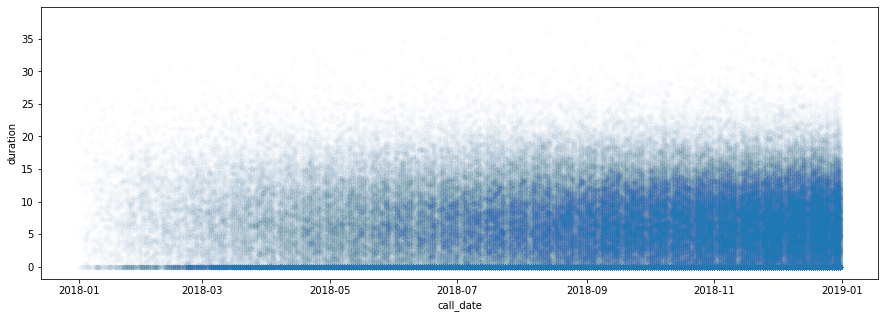

In [8]:
df_calls.plot(x='call_date',y='duration', kind='scatter', alpha = 0.01, figsize=(15,5))

<font color='DarkBlue'> 
📌 Данных больше к концу года, в чем еще раз можно убедиться, исходя из анализа графика. Видимо, такое положение связано с увеличением количества пользователей, перешедших на новые тарифы и использующих их <br> 
📌 В дальнейших расчетах появится необходимость использования значений продолжительности разговоров в минутах, округленных в большую сторону, поэтому можно создать соответствующий столбец <br> 
</font> 

In [9]:
df_calls['mins'] = df_calls['duration'].apply(lambda x: math.ceil(x))
df_calls.head()

,id,call_date,duration,user_id,is_call,mins
0,0,2018-07-25,0.00,1000,False,0
1,1,2018-08-17,0.00,1000,False,0
2,2,2018-06-11,2.85,1000,True,3
3,3,2018-09-21,13.80,1000,True,14
4,4,2018-12-15,5.18,1000,True,6


### Датасет 'internet'

In [10]:
# Загрузка таблицы в память переменной df_internet типа dataframe
df_internet = pd.read_csv('/datasets/internet.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df_internet.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df_internet.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df_internet.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df_internet.head())
print('Количество явных дубликатов',df_internet.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
 ----- Информация о заголовках полей dataframe ----- 
Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
Unnamed: 0        int64
id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных таблицы 'internet' сделаны следующие выводы:
    
1. Все заголовки выведены в удобном для работы с ними формате за исключением 'Unnamed: 0'. Скорее всего данные этого столбца дублируют значение индекса. Нужно проверить, определив количество несовпадающих значений в данных указанного предположения
2. Отсутствуют пропуски и явные дубликаты
3. Тип данных поля 'session_date' необходимо преобразовать. Часть данных строкового поля 'id' скорее всего повторяет значение поля 'user_id'. Можно проверить, определив количество несовпадающих значений в данных указанного предположения
</font> 

In [11]:
print('Количество несовпадающих значений идентификаторов пользователей в полях \'id\' и \'user_id\'',df_internet[df_internet['id'].apply(lambda x: x.split('_')[0]).astype('int') != df_internet['user_id']]['user_id'].count())
print('Количество несовпадающих значений идентификаторов строк в полях \'index\' и \'Unnamed: 0\'',df_internet[df_internet.index != df_internet['Unnamed: 0']]['Unnamed: 0'].count())

Количество несовпадающих значений идентификаторов пользователей в полях 'id' и 'user_id' 0
Количество несовпадающих значений идентификаторов строк в полях 'index' и 'Unnamed: 0' 0


<font color='DarkBlue'> 
📌 Так как рассматриваемые значения идентификаторов пользователей полностью дублируются, можно убрать первую часть записи поля 'id' и уже преобразовать тип данных в более легковесный по объему занимаемой памяти целочисленный <br>
📌 Исходя из того, что нет отличающихся значений индекса и поля 'Unnamed: 0', можно сделать вывод, что значения индекса и поля 'Unnamed: 0' совпадают и необходимо удалить дублирующий индекс столбец 'Unnamed: 0' или получить данные таблицы с указанием первой колонки в качестве индекса  
</font> 

In [12]:
# Загрузка таблицы в память переменной df_internet типа dataframe
df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
display(df_internet.head())

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<font color='DarkBlue'> 
📌 Теперь можно преобразовать тип данных поля 'session_date' <br>  
📌 Так же можно проверить типы данных датафрейма после их преобразований, вывести его на экран проверить корректность данных <br>  
</font> 

In [13]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

In [14]:
df_internet['id'] = df_internet['id'].apply(lambda x: x.split('_')[1]).astype('int')
#df_internet.drop(columns = ['Unnamed: 0'],axis = 1, inplace=True)
display(df_internet.head())
print(df_internet.dtypes)

,id,mb_used,session_date,user_id
0,0,112.95,2018-11-25,1000
1,1,1052.81,2018-09-07,1000
2,2,1197.26,2018-06-25,1000
3,3,550.27,2018-08-22,1000
4,4,302.56,2018-09-24,1000


id                       int64
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object


<font color='DarkBlue'> 
📌 Теперь нужно проанализировать основные свойства значений полей <br>  
</font> 

In [15]:
display(df_internet.describe())
for i in df_internet.select_dtypes(include=['object','bool','datetime']):
    print('-----')
    display(df_internet[i].describe(datetime_is_numeric=True))
    if df_internet[i].count() != len(df_internet[i].unique()):
        print(df_internet[i].value_counts())
    else:
        print('Все значения уникальны')

,id,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,205.811856,370.192426,1252.099842
std,157.267497,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,78.000000,138.187500,1130.000000
50%,172.000000,348.015000,1251.000000
75%,302.000000,559.552500,1380.000000
max,833.000000,1724.830000,1499.000000


-----


count                           149396
mean     2018-09-02 12:55:35.221826560
min                2018-01-01 00:00:00
25%                2018-07-05 00:00:00
50%                2018-09-17 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: session_date, dtype: object

2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
              ... 
2018-01-05      14
2018-01-04       9
2018-01-03       6
2018-01-02       3
2018-01-01       3
Name: session_date, Length: 365, dtype: int64


<font color='DarkBlue'> 
📌 В данных таблицы некорректные значения не наблюдаются, за исключением записей с нулевым количеством траффика. Нужно уточнить количество подобных записей. В случае обнаружения большого количества строк с подобной аномалией и наличия логичного объяснения данному явлению удалять их будет не желательно <br> 
📌 Количество записей с информацией об использовании  интернет-траффика рассматриваемыми пользователями постоянно увеличивается ближе к концу года <br> 
📌 В среднем по 172 записи с данными по каждому пользователю <br>     
</font> 

In [16]:
print('Количество подключений без траффика',df_internet[df_internet['mb_used'] == 0]['mb_used'].count())

Количество подключений без траффика 19598


<font color='DarkBlue'> 
📌 Количество записей с отсутствием траффика умеренно большое, но все же их намного меньше, чем с каким-либо значением. Можно предположить, что уже этому явлению нет логичного объяснения, и обновить таблицу, убрав соответствующие записи <br> 
</font> 

In [17]:
df_internet = df_internet[df_internet['mb_used'] > 0]

<font color='DarkBlue'> 
📌 Дополнительно можно проанализировать изменение объема траффика или количества записей в течение года <br> 
</font> 

<AxesSubplot:xlabel='session_date', ylabel='mb_used'>

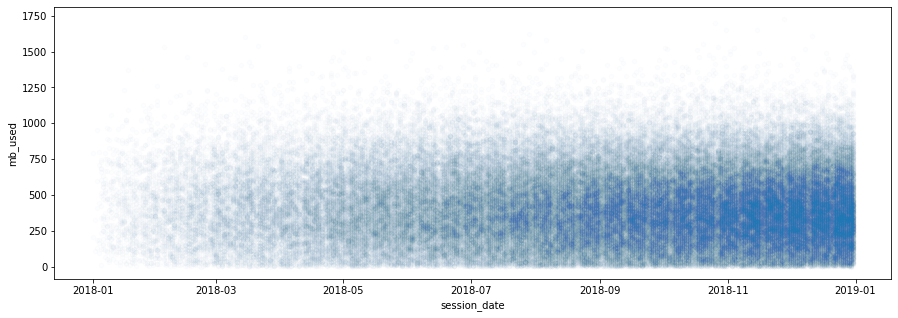

In [18]:
df_internet.plot(x='session_date',y='mb_used', kind='scatter', alpha = 0.01 , figsize=(15,5))

<font color='DarkBlue'> 
📌 Данных больше к концу года, в чем еще раз можно убедиться, исходя из анализа графика. Такое положение также связано с увеличением количества пользователей, перешедших на новые тарифы и использующих их <br> 
</font> 

### Датасет 'messages'

In [19]:
# Загрузка таблицы в память переменной df_messages типа dataframe
df_messages = pd.read_csv('/datasets/messages.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df_messages.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df_messages.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df_messages.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df_messages.head())
print('Количество явных дубликатов',df_messages.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
 ----- Информация о заголовках полей dataframe ----- 
Index(['id', 'message_date', 'user_id'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
id              object
message_date    object
user_id          int64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных таблицы 'messages' сделаны следующие выводы:
    
1. Все заголовки выведены в удобном для работы с ними формате, редактирование не требуется
2. Отсутствуют пропуски и явные дубликаты
3. Тип данных поля 'message_date' необходимо преобразовать. Часть данных строкового поля 'id' скорее всего повторяет значение поля 'user_id'. Можно проверить, определив количество несовпадающих значений в данных указанного предположения
</font> 

In [20]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
print('Количество несовпадающих значений идентификаторов пользователей в полях \'id\' и \'user_id\'',df_messages[df_messages['id'].apply(lambda x: x.split('_')[0]).astype('int') != df_messages['user_id']]['user_id'].count())

Количество несовпадающих значений идентификаторов пользователей в полях 'id' и 'user_id' 0


<font color='DarkBlue'> 
📌 Так как рассматриваемые значения идентификаторов пользователей полностью дублируются, можно убрать первую часть записи поля 'id' и уже преобразовать тип данных в более легковесный по объему занимаемой памяти целочисленный <br>
📌 Так же можно проверить типы данных датафрейма после их преобразований, вывести его на экран проверить корректность данных <br>    
</font> 

In [21]:
df_messages['id'] = df_messages['id'].apply(lambda x: x.split('_')[1]).astype('int')
display(df_messages.head())
print(df_messages.dtypes)

,id,message_date,user_id
0,0,2018-06-27,1000
1,1,2018-10-08,1000
2,2,2018-08-04,1000
3,3,2018-06-16,1000
4,4,2018-12-05,1000


id                       int64
message_date    datetime64[ns]
user_id                  int64
dtype: object


<font color='DarkBlue'> 
📌 Теперь нужно проанализировать основные свойства значений полей <br>  
</font> 

In [22]:
display(df_messages.describe())
for i in df_messages.select_dtypes(include=['object','bool','datetime']):
    print('-----')
    display(df_messages[i].describe(datetime_is_numeric=True))
    if df_messages[i].count() != len(df_messages[i].unique()):
        print(df_messages[i].value_counts())
    else:
        print('Все значения уникальны')

,id,user_id
count,123036.000000,123036.000000
mean,267.595281,1256.989410
std,248.577464,143.523967
min,0.000000,1000.000000
25%,81.000000,1134.000000
50%,195.000000,1271.000000
75%,379.000000,1381.000000
max,1462.000000,1499.000000


-----


count                           123036
mean     2018-09-04 15:28:42.227640576
min                2018-01-02 00:00:00
25%                2018-07-09 00:00:00
50%                2018-09-20 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: message_date, dtype: object

2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-26    699
             ... 
2018-01-07     12
2018-01-05     10
2018-01-02     10
2018-01-04     10
2018-01-03      4
Name: message_date, Length: 364, dtype: int64


<font color='DarkBlue'> 
📌 В данных таблицы некорректные значения не наблюдаются <br> 
📌 Количество записей с информацией об отправленных сообщениях рассматриваемыми пользователями постоянно увеличивается ближе к концу года <br> 
📌 В среднем по 196 записей с данными по каждому пользователю <br>      
📌 Дополнительно можно проанализировать количество сообщений в течение года <br>  
</font> 

<AxesSubplot:>

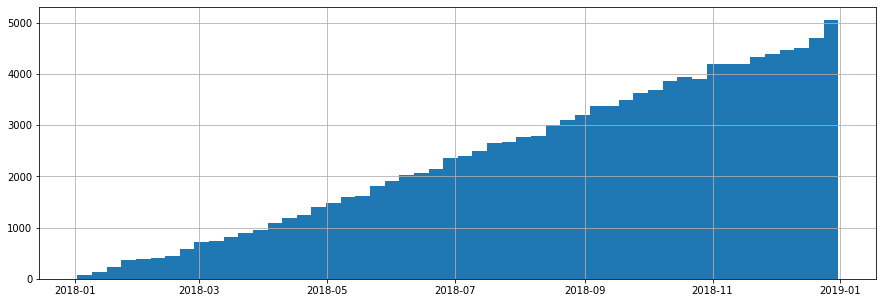

In [23]:
df_messages['message_date'].hist(bins=52, figsize=(15,5))

<font color='DarkBlue'> 
📌 Данных больше к концу года, в чем еще раз можно убедиться, исходя из анализа графика <br> 
</font> 

### Датасет 'tariffs'

In [24]:
# Загрузка таблицы в память переменной df_tariffs типа dataframe
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df_tariffs.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df_tariffs.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df_tariffs.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df_tariffs.head())
print('Количество явных дубликатов',df_tariffs.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
 ----- Информация о заголовках полей dataframe ----- 
Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')
 ----- Информация о типах полей da

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных таблицы 'tariffs' сделаны следующие выводы:
    
1. Все заголовки выведены в удобном для работы с ними формате, редактирование не требуется
2. Визуально прослеживается, что тсутствуют пропуски и явные дубликаты
3. Для информации можно проанализировать основные свойства значений полей стандартным методом <br>
</font> 

In [25]:
display(df_tariffs.describe())
for i in df_tariffs.select_dtypes(include=['object','bool','datetime']):
    print('-----')
    display(df_tariffs[i].describe(datetime_is_numeric=True))
    if df_tariffs[i].count() != len(df_tariffs[i].unique()):
        print(df_tariffs[i].value_counts())
    else:
        print('Все значения уникальны')

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


-----


count         2
unique        2
top       ultra
freq          1
Name: tariff_name, dtype: object

Все значения уникальны


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных таблицы 'tariffs' сделаны следующие выводы:
    
1. Все заголовки выведены в удобном для работы с ними формате, редактирование не требуется
2. Отсутствуют пропуски и явные дубликаты
3. Необходимость в преобразовании типов данных полей отсутствует, можно оставить таблицу в первоначальном виде
</font>

### Датасет 'users'

In [26]:
# Загрузка таблицы в память переменной df_users типа dataframe
df_users = pd.read_csv('/datasets/users.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df_users.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df_users.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df_users.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df_users.head())
print('Количество явных дубликатов',df_users.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
 ----- Информация о заголовках полей dataframe ----- 
Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')
 ----- Информация о типах полей dataframe ----- 
user_id        int64
age            int64
churn_date    object
city          object
first_name    object
last_name     object
reg_date      object
tariff        obj

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных таблицы 'users' сделаны следующие выводы:
    
1. Все заголовки выведены в удобном для работы с ними формате, редактирование не требуется
2. Отсутствуют явные дубликаты, но есть пропуски в столбце 'churn_date'. Исходя из задания, если значение пропущено, то тариф ещё действовал на момент выгрузки данных, следовательно можно добавить столбец, сигнаизирующий о наличии указанного факта
3. Тип данных полей 'churn_date' и 'reg_date' необходимо преобразовать
4. Каждый из рассматриваемых пользователей произвел подключение к тарифу в исследуемом периоде
</font> 

In [27]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['is_client'] = df_users['churn_date'].isna()
display(df_users.head())
print(df_users.dtypes)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,is_client
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,True
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,True
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,True
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,True
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,True


user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
is_client               bool
dtype: object


<font color='DarkBlue'> 
📌 Можно добавить столбец с количеством дней использования тарифа для каждого пользователя
</font> 

In [28]:
df_users['days_used'] = (df_users['churn_date'] - df_users['reg_date']).dt.days
df_users['days_used'] = df_users['days_used'].fillna((pd.to_datetime('2018-12-31', format='%Y-%m-%d') - df_users['reg_date']).dt.days)
df_users['days_used'] = df_users['days_used'] .astype('int')
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,is_client,days_used
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,True,220
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,True,60
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,True,197
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,True,136
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,True,231


<font color='DarkBlue'> 
📌 Для информации можно вывести данные пользователей, прекративших использование тарифа
</font> 

In [29]:
display(df_users[~df_users['churn_date'].isna()].head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,is_client,days_used
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra,False,142
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart,False,57
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart,False,87
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,False,109
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart,False,139


<font color='DarkBlue'> 
📌 Для проверки гипотез в дальнейшем желательно разделить пользователей на 2 категории: из Москвы и других регионов, создав новый соответствующий столбец
</font> 

In [30]:
df_users['location'] = df_users['city'].where(df_users['city'] == 'Москва','other')

<font color='DarkBlue'> 
📌 Теперь нужно проанализировать основные свойства значений полей <br>  
</font> 

In [31]:
display(df_users.describe())
for i in df_users.select_dtypes(include=['object','bool','datetime']):
    print('-----')
    display(df_users[i].describe(datetime_is_numeric=True))
    if df_users[i].count() != len(df_users[i].unique()):
        print(df_users[i].value_counts())
    else:
        print('Все значения уникальны')

,user_id,age,days_used
count,500.000000,500.00000,500.0000
mean,1249.500000,46.58800,179.5640
std,144.481833,16.66763,102.7157
min,1000.000000,18.00000,0.0000
25%,1124.750000,32.00000,88.7500
50%,1249.500000,46.00000,177.0000
75%,1374.250000,62.00000,264.0000
max,1499.000000,75.00000,364.0000


-----


count                               38
mean     2018-11-13 00:37:53.684210432
min                2018-08-17 00:00:00
25%                2018-10-14 00:00:00
50%                2018-11-24 00:00:00
75%                2018-12-15 12:00:00
max                2018-12-30 00:00:00
Name: churn_date, dtype: object

2018-10-03    2
2018-12-09    2
2018-12-03    2
2018-12-21    2
2018-10-14    2
2018-12-30    1
2018-12-16    1
2018-08-31    1
2018-08-17    1
2018-11-27    1
2018-10-04    1
2018-11-21    1
2018-11-07    1
2018-11-26    1
2018-12-25    1
2018-12-11    1
2018-09-26    1
2018-10-27    1
2018-12-14    1
2018-11-13    1
2018-09-02    1
2018-11-30    1
2018-11-16    1
2018-12-20    1
2018-10-05    1
2018-11-22    1
2018-12-23    1
2018-10-25    1
2018-12-26    1
2018-09-27    1
2018-10-28    1
2018-12-18    1
2018-12-24    1
Name: churn_date, dtype: int64
-----


count        500
unique        76
top       Москва
freq          99
Name: city, dtype: object

Москва             99
Санкт-Петербург    39
Новосибирск        16
Казань             14
Омск               14
                   ..
Подольск            1
Химки               1
Архангельск         1
Нижневартовск       1
Иваново             1
Name: city, Length: 76, dtype: int64
-----


count       500
unique      246
top       Радим
freq          6
Name: first_name, dtype: object

Радим         6
Пётр          5
Леонид        5
Кристина      4
Тамара        4
             ..
Владислава    1
Берта         1
Милена        1
Людмила       1
Станислав     1
Name: first_name, Length: 246, dtype: int64
-----


count           500
unique          419
top       Андреенко
freq              5
Name: last_name, dtype: object

Андреенко    5
Булгаков     3
Анищенко     3
Березина     3
Аркадьев     3
            ..
Астапенко    1
Шевцова      1
Розанова     1
Антропова    1
Аракчеев     1
Name: last_name, Length: 419, dtype: int64
-----


count                              500
mean     2018-06-30 18:57:35.999999744
min                2018-01-01 00:00:00
25%                2018-04-07 12:00:00
50%                2018-07-02 12:00:00
75%                2018-09-29 00:00:00
max                2018-12-31 00:00:00
Name: reg_date, dtype: object

2018-05-28    8
2018-04-03    5
2018-01-04    5
2018-11-16    5
2018-10-05    5
             ..
2018-06-23    1
2018-12-25    1
2018-05-08    1
2018-06-08    1
2018-12-21    1
Name: reg_date, Length: 270, dtype: int64
-----


count       500
unique        2
top       smart
freq        351
Name: tariff, dtype: object

smart    351
ultra    149
Name: tariff, dtype: int64
-----


count      500
unique       2
top       True
freq       462
Name: is_client, dtype: object

True     462
False     38
Name: is_client, dtype: int64
-----


count       500
unique        2
top       other
freq        401
Name: location, dtype: object

other     401
Москва     99
Name: location, dtype: int64


<font color='DarkBlue'> 
📌 В данных таблицы некорректные значения не наблюдаются <br> 
📌 Большинство пользуется тарифом "smart" и находится в крупных городах и продолжает пользоваться тарифом, а отключившиеся приняли соответсвующее решение в конце года <br> 
📌 Наиболее частое имя пользователя "Радим". Скорее всего "Вадим", но записи скорее всего заполнялись независимо, поэтому предполагается оставить данные без изменений <br>     
📌 Дополнительно можно проанализировать подключений и отключений тарифа в течение года <br> 
</font> 

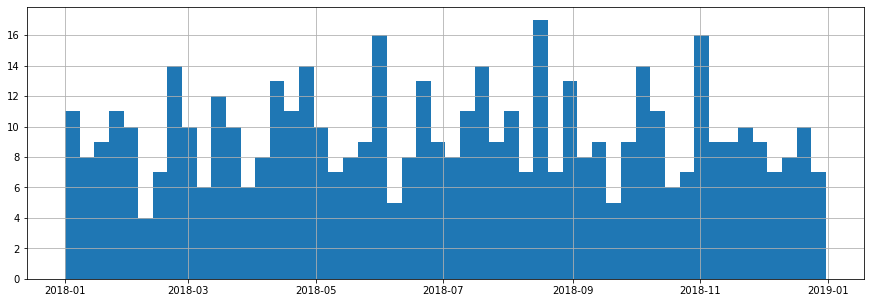

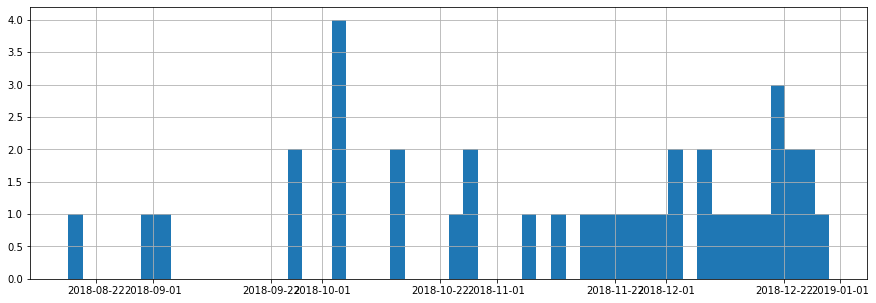

In [32]:
df_users['reg_date'].hist(bins=52, figsize=(15,5))
plt.show()
df_users['churn_date'].hist(bins=52, figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 Данные по подключениям к тарифу равномерно распределены в течение года, но большинство отключается ближе к концу года (в связи с отсутствием необходимости, переходом к другому оператору, на другой тариф и т.д.). Следовательно количество пользователей в рассматриваемом периоде постепенно увеличивалось <br> 
📌 Можно проанализировать количество пользователей, сменивших каждый тариф для выявления наиболее удовлетворяющего потребности клиентов <br> 
</font> 

In [33]:
df_users.groupby('tariff')[['reg_date','churn_date']].count()

,reg_date,churn_date
tariff,,
smart,351,23
ultra,149,15


<font color='DarkBlue'> 
📌 Как видно из соотношения, большее количество пользователей меняет тариф после использования варианта 'ультра' <br> 
📌 Выбивыющихся аномалий в исходных данных нет, поэтому в дальнейших расчетах можно использовать среднее арифметическое значение для анализа всех данных <br> 
</font> 

## Расчеты и подготовка данных к анализу

<font color='DarkBlue'> 
📌 Для дальнейшего анализа необходимо составить общую таблицу с выручкой по каждому пользователю и месяцу. Для этого необходимо собрать данные по данным пользования каждой из услуг из нескольких исходных датафреймов <br>
📌 Необходимо создать таблицу с количеством осуществленных звонков и израсходованных минут разговора для каждого пользователя по месяцам, для чего можно выделить месяц пользования услугой для каждой записи таблицы 'df_calls', затем реализовать сводную таблицу. Также можно создать дополнительную таблицу для анализа, выделив графу для среднего количества пользования сервисом по каждому пользователю в течение рассматриваемого периода, используя обобщенное значение количества израсходованных минут <br> 
📌 В более глубоком анализе даже с учетом того, что абонентская плата может сниматься в любом числе месяца для каждого пользователя можно удалить первый столбец с месяцем, в котором присутствуют данные, так как он не является информативным по причине того, что пользователь мог подключить тариф в любое время месяца и не использовать все услуги в полном объеме и стандартном режиме, а также последний месяц пользования сервисом в случае, если клиент уже не является пользователем этого тарифа <br> 
</font> 

In [34]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls['min_month'] = df_calls.groupby('user_id')['month'].transform('min')
df_calls['max_month'] = df_calls[df_calls['user_id'].isin(df_users[~df_users['is_client']]['user_id'].unique())].groupby('user_id')['month'].transform('max')
df_calls_test = df_calls.copy()
df_calls = df_calls[(df_calls['month'] != df_calls['min_month']) & (df_calls['month'] != df_calls['max_month'])]
df_agg_month = df_calls.groupby(['user_id','month'])['mins'].agg(['sum','count'])
display(df_agg_month)
df_agg_mean = pd.DataFrame(round(df_calls.groupby('user_id')['mins'].sum() / df_calls.groupby('user_id')['month'].unique().apply(lambda x: len(x)), 2))
display(df_agg_mean)

sum  count
user_id month            
1000    6      172     43
        7      340     47
        8      408     52
        9      466     58
        10     350     57
...            ...    ...
1498    8      400     57
        9      471     59
1499    10     449     68
        11     612     74
        12     492     69

[2646 rows x 2 columns]

,0
user_id,
1000,343.86
1001,414.00
1002,233.33
1003,860.50
1004,136.00
...,...
1495,957.00
1496,539.64
1497,458.00


In [35]:
# df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
# df_calls['min_month'] = df_calls.groupby('user_id')['month'].transform('min')
# df_calls['max_month'] = df_calls[df_calls['user_id'].isin(df_users[~df_users['is_client']]['user_id'].unique())].groupby('user_id')['month'].transform('max')
# df_calls = df_calls[(df_calls['month'] != df_calls['min_month']) & (df_calls['month'] != df_calls['max_month'])]
# df_calls_month = df_calls.pivot_table(index = 'user_id', columns = 'month', values = 'mins', aggfunc = ['sum','count'], dropna=False)
# df_calls_month.columns = ['2_sum_calls','3_sum_calls','4_sum_calls','5_sum_calls','6_sum_calls','7_sum_calls','8_sum_calls','9_sum_calls','10_sum_calls','11_sum_calls','12_sum_calls','2_cnt_calls','3_cnt_calls','4_cnt_calls','5_cnt_calls','6_cnt_calls','7_cnt_calls','8_cnt_calls','9_cnt_calls','10_cnt_calls','11_cnt_calls','12_cnt_calls']
# df_calls_month['mean_sum_calls'] = df_calls.pivot_table(index = 'user_id', values = 'mins', aggfunc = 'sum', dropna=False)
# df_calls_month = pd.merge(df_users['user_id'], df_calls_month, on='user_id', how='left')
# df_calls_month['mean_sum_calls'] /= (df_calls_month.apply(lambda x: sum(~x.isnull().values), axis = 1) - 2) / 2
# df_calls_month['mean_sum_calls'] = round(df_calls_month['mean_sum_calls'], 2)
# display(df_calls_month)

<font color='DarkBlue'> 
📌 Присутствует большое количество пропущенных значений (количество строк не равно значению 500 * 11), так как пользователи подключались к новому тарифу постепенно в течение года <br>
📌 Необходимо дополнить таблицу с количеством отправленных сообщений по месяцам для каждого пользователя, пользуясь тем же принципом ее построения, что и в примере выше <br> 
📌 Также удаление первого и последнего столбцов месяцев пользования тарифом в течение рассматриваемого периода при необходимости позволит организовать более точный расчет для анализа пользования услугой, что касается и анализа следующей услуги <br>
</font> 

In [36]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_messages['min_month'] = df_messages.groupby('user_id')['month'].transform('min')
df_messages['max_month'] = df_messages[df_messages['user_id'].isin(df_users[~df_users['is_client']]['user_id'].unique())].groupby('user_id')['month'].transform('max')
df_messages_test = df_messages.copy()
df_messages = df_messages[(df_messages['month'] != df_messages['min_month']) & (df_messages['month'] != df_messages['max_month'])]
df_agg_month = pd.merge(df_agg_month, df_messages.groupby(['user_id','month'])['id'].agg(['count']), on=['user_id','month'], how='outer', suffixes=('_calls','_messages')).sort_values(['user_id','month'])
display(df_agg_month)
df_agg_mean = pd.merge(df_agg_mean, pd.DataFrame(round(df_messages.groupby('user_id')['id'].count() / df_messages.groupby('user_id')['month'].unique().apply(lambda x: len(x)), 2)), on='user_id', how='outer')
df_agg_mean

sum  count_calls  count_messages
user_id month                                    
1000    6      172.0         43.0            60.0
        7      340.0         47.0            75.0
        8      408.0         52.0            81.0
        9      466.0         58.0            57.0
        10     350.0         57.0            73.0
...              ...          ...             ...
1498    8      400.0         57.0            62.0
        9      471.0         59.0            44.0
1499    10     449.0         68.0            48.0
        11     612.0         74.0            59.0
        12     492.0         69.0            66.0

[2679 rows x 3 columns]

,0_x,0_y
user_id,,
1000,343.86,67.71
1001,414.00,NaN
1002,233.33,11.00
1003,860.50,85.75
1004,136.00,156.71
...,...,...
1106,NaN,27.00
1231,NaN,189.86
1328,NaN,7.50


In [37]:
# df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
# df_messages['min_month'] = df_messages.groupby('user_id')['month'].transform('min')
# df_messages['max_month'] = df_messages[df_messages['user_id'].isin(df_users[~df_users['is_client']]['user_id'].unique())].groupby('user_id')['month'].transform('max')
# df_messages = df_messages[(df_messages['month'] != df_messages['min_month']) & (df_messages['month'] != df_messages['max_month'])]
# df_messages_month = df_messages.pivot_table(index = 'user_id', columns = 'month', values = 'id', aggfunc = 'count', dropna=False)
# df_messages_month['mean_messages'] = df_messages.pivot_table(index = 'user_id', values = 'id', aggfunc = 'count', dropna=False)
# df_messages_month = pd.merge(df_users['user_id'], df_messages_month, on='user_id', how='left')
# df_messages_month['mean_messages'] /= (df_messages_month.apply(lambda x: sum(~x.isnull().values), axis = 1) - 2)
# df_messages_month['mean_messages'] = round(df_messages_month['mean_messages'], 2)
# df_messages_month

<font color='DarkBlue'> 
📌 По прежнему наблюдается большое количество отсутствующих значений <br>
📌 Необходимо в очередной раз дополнить таблицу значениями с объемом израсходованного интернет-трафика по месяцам для каждого пользователя, пользуясь тем же принципом ее построения, что и в примерах выше. Значения можно округлить до гигабайт в большую сторону, но исходные дадут наиболее подробную картину, так как учет организовывается только в конце каждого месяца и он может исказить усредненное значение, рассчитываемое далее <br> 
</font> 

In [38]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_internet['min_month'] = df_internet.groupby('user_id')['month'].transform('min')
df_internet['max_month'] = df_internet[df_internet['user_id'].isin(df_users[~df_users['is_client']]['user_id'].unique())].groupby('user_id')['month'].transform('max')
df_internet_test = df_internet.copy()
df_internet = df_internet[(df_internet['month'] != df_internet['min_month']) & (df_internet['month'] != df_internet['max_month'])]
df_agg_month = pd.merge(df_agg_month, df_internet.groupby(['user_id','month'])['mb_used'].agg(['sum']), on=['user_id','month'], how='outer', suffixes=('_calls','_internet')).sort_values(['user_id','month'])
display(df_agg_month)
df_agg_mean = pd.merge(df_agg_mean, pd.DataFrame(round(df_internet.groupby('user_id')['mb_used'].sum() / df_internet.groupby('user_id')['month'].unique().apply(lambda x: len(x)), 2)), on='user_id', how='outer')
df_agg_mean.columns = ['calls','messages','internet']
df_agg_mean

sum_calls  count_calls  count_messages  sum_internet
user_id month                                                      
1000    6          172.0         43.0            60.0      23233.77
        7          340.0         47.0            75.0      14003.64
        8          408.0         52.0            81.0      14055.93
        9          466.0         58.0            57.0      14568.91
        10         350.0         57.0            73.0      14702.49
...                  ...          ...             ...           ...
1498    8          400.0         57.0            62.0      24235.21
        9          471.0         59.0            44.0      22134.41
1499    10         449.0         68.0            48.0      17788.51
        11         612.0         74.0            59.0      17963.31
        12         492.0         69.0            66.0      13055.58

[2680 rows x 4 columns]

,calls,messages,internet
user_id,,,
1000,343.86,67.71,15019.83
1001,414.00,NaN,14036.66
1002,233.33,11.00,17529.95
1003,860.50,85.75,12178.86
1004,136.00,156.71,19376.50
...,...,...,...
1106,NaN,27.00,19155.05
1231,NaN,189.86,30238.50
1328,NaN,7.50,37472.66


In [39]:
# df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
# df_internet['min_month'] = df_internet.groupby('user_id')['month'].transform('min')
# df_internet['max_month'] = df_internet[df_internet['user_id'].isin(df_users[~df_users['is_client']]['user_id'].unique())].groupby('user_id')['month'].transform('max')
# df_internet = df_internet[(df_internet['month'] != df_internet['min_month']) & (df_internet['month'] != df_internet['max_month'])]
# df_internet_month = df_internet.pivot_table(index = 'user_id', columns = 'month', values = 'mb_used', aggfunc = 'sum', dropna=False)
# df_internet_month['mean_internet'] = df_internet.pivot_table(index = 'user_id', values = 'mb_used', aggfunc = 'sum', dropna=False)
# df_internet_month = pd.merge(df_users['user_id'], df_internet_month, on='user_id', how='left')
# df_internet_month['mean_internet'] /= (df_internet_month.apply(lambda x: sum(~x.isnull().values), axis = 1) - 2)
# df_internet_month['mean_internet'] = round(df_internet_month['mean_internet'], 2)
# df_internet_month

<font color='DarkBlue'> 
📌 Необходимо скорректировать полученный датафрейм для возможности проведения дальнейших арифметических операций между всеми его значениями, заменив отсутствующие значения на нулевые <br> 
📌 Теперь нужно определить помесячную выручку с каждого пользователя из объединенной таблицы, вычев бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, а остаток умножив на значение из тарифного плана и прибавив соответствующую абонентскую плату <br> 
📌 Также при необходимости, если того требует задание, можно определить, какая услуга наиболее прибыльная, для оптимизации тарифных ставок и лимитов по каждой из них, для чего нужно обозначить обобщенную выручку по каждому сервису и сгруппировать таблицу по используемым тарифам и усредненным значениям указанных параметров <br> 
</font> 

In [40]:
df_agg_month.isna().sum()

sum_calls          34
count_calls        34
count_messages    418
sum_internet       12
dtype: int64

In [41]:
df_agg_month = df_agg_month.fillna(0)

In [42]:
#df_agg_month['cash'] = df_tariffs[df_tariffs['tariff_name'] == df_users[df_agg_month.index == df_users['user_id']]['tariff']]['minutes_included']
#df_agg_month['user_id'] = df_agg_month.index.get_level_values(0)
#df_agg_month['month'] = df_agg_month.index.get_level_values(1)
df_agg_month = df_agg_month.reset_index()
df_agg_month = pd.merge(df_agg_month, df_users[['user_id','tariff', 'location']], on = 'user_id', how = 'left')
df_agg_month = pd.merge(df_agg_month, df_tariffs[['tariff_name','minutes_included', 'rub_per_minute', 'messages_included','rub_per_message','mb_per_month_included','rub_per_gb','rub_monthly_fee']], left_on = 'tariff', right_on = 'tariff_name', how = 'left')
df_agg_month['calls_cash'] = ((df_agg_month['sum_calls'] - df_agg_month['minutes_included']).where((df_agg_month['sum_calls'] - df_agg_month['minutes_included']) > 0, 0) * df_agg_month['rub_per_minute']).astype('int')
df_agg_month['message_cash'] = ((df_agg_month['count_messages'] - df_agg_month['messages_included']).where((df_agg_month['count_messages'] - df_agg_month['messages_included']) > 0, 0) * df_agg_month['rub_per_message']).astype('int')
df_agg_month['internet_cash'] = ((((df_agg_month['sum_internet'] - df_agg_month['mb_per_month_included']) / 1024).fillna(0).apply(lambda x: math.ceil(x))).where((df_agg_month['sum_internet'] - df_agg_month['mb_per_month_included']) > 0, 0) * df_agg_month['rub_per_gb']).astype('int')
df_agg_month['temp_cash'] = (df_agg_month['rub_monthly_fee'].where((df_agg_month['sum_calls'] > 0) | (df_agg_month['count_messages'] > 0) | (df_agg_month['sum_internet'] > 0), 0)).astype('int')
df_agg_month['total_cash'] = ((df_agg_month['sum_calls'] - df_agg_month['minutes_included']).where((df_agg_month['sum_calls'] - df_agg_month['minutes_included']) > 0, 0) * df_agg_month['rub_per_minute'] + (df_agg_month['count_messages'] - df_agg_month['messages_included']).where((df_agg_month['count_messages'] - df_agg_month['messages_included']) > 0, 0) * df_agg_month['rub_per_message'] + (((df_agg_month['sum_internet'] - df_agg_month['mb_per_month_included']) / 1024).fillna(0).apply(lambda x: math.ceil(x))).where((df_agg_month['sum_internet'] - df_agg_month['mb_per_month_included']) > 0, 0) * df_agg_month['rub_per_gb'] + df_agg_month['rub_monthly_fee'].where((df_agg_month['sum_calls'] > 0) | (df_agg_month['count_messages'] > 0) | (df_agg_month['sum_internet'] > 0), 0)).astype('int')
df_agg_month = df_agg_month.drop(['tariff_name','minutes_included', 'rub_per_minute', 'messages_included','rub_per_message','mb_per_month_included','rub_per_gb','rub_monthly_fee'],axis = 1)
df_agg_month.set_index(['user_id','month'], inplace=True)
df_agg_month

sum_calls  count_calls  count_messages  sum_internet tariff  \
user_id month                                                                
1000    6          172.0         43.0            60.0      23233.77  ultra   
        7          340.0         47.0            75.0      14003.64  ultra   
        8          408.0         52.0            81.0      14055.93  ultra   
        9          466.0         58.0            57.0      14568.91  ultra   
        10         350.0         57.0            73.0      14702.49  ultra   
...                  ...          ...             ...           ...    ...   
1498    8          400.0         57.0            62.0      24235.21  smart   
        9          471.0         59.0            44.0      22134.41  smart   
1499    10         449.0         68.0            48.0      17788.51  smart   
        11         612.0         74.0            59.0      17963.31  smart   
        12         492.0         69.0            66.0      13055.58  smart   

              location  calls_cash  message_cash  internet_cash  temp_cash  \
user_id month                                                                
1000    6        other           0             0              0       1950   
        7        other           0             0              0       1950   
        8        other           0             0              0       1950   
        9        other           0             0              0       1950   
        10       other           0             0              0       1950   
...                ...         ...           ...            ...        ...   
1498    8        other           0            36           1800        550   
        9        other           0             0           1400        550   
1499    10       other           0             0            600        550   
        11       other         336            27            600        550   
        12       other           0            48              0        550   

               total_cash  
user_id month              
1000    6            1950  
        7            1950  
        8            1950  
        9            1950  
        10           1950  
...                   ...  
1498    8            2386  
        9            1950  
1499    10           1150  
        11           1513  
        12            598  

[2680 rows x 11 columns]

In [43]:
# df_joined = df_users.rename(columns={'tariff': 'tariff_name'})
# df_joined = pd.merge(df_joined, df_tariffs, on='tariff_name', how='left')
# df_joined = pd.merge(df_joined, df_calls_month, on='user_id', how='left')
# df_joined = pd.merge(df_joined, df_messages_month, on='user_id', how='left')
# df_joined = pd.merge(df_joined, df_internet_month, on='user_id', how='left', suffixes=('_messages','_internet'))
# df_joined['calls_cash'] = df_joined['message_cash'] = df_joined['internet_cash'] = 0
# for i in range(2,13):
#     total = str(i) + '_cash'
#     sum_calls = str(i) + '_sum_calls'
#     sum_messages = str(i) + '_messages'
#     sum_internet = str(i) + '_internet'
#     df_joined[total] = ((df_joined[sum_calls] - df_joined['minutes_included']).where((df_joined[sum_calls] - df_joined['minutes_included']) > 0, 0) * df_joined['rub_per_minute'] + (df_joined[sum_messages] - df_joined['messages_included']).where((df_joined[sum_messages] - df_joined['messages_included']) > 0, 0) * df_joined['rub_per_message'] + (((df_joined[sum_internet] - df_joined['mb_per_month_included']) / 1024).fillna(0).apply(lambda x: math.ceil(x))).where((df_joined[sum_internet] - df_joined['mb_per_month_included']) > 0, 0) * df_joined['rub_per_gb'] + df_joined['rub_monthly_fee'].where((df_joined[sum_calls] > 0) | (df_joined[sum_messages] > 0) | (df_joined[sum_internet] > 0), 0)).astype('int')
#     df_joined['calls_cash'] += (df_joined[sum_calls] - df_joined['minutes_included']).where((df_joined[sum_calls] - df_joined['minutes_included']) > 0, 0) * df_joined['rub_per_minute']
#     df_joined['message_cash'] += (df_joined[sum_messages] - df_joined['messages_included']).where((df_joined[sum_messages] - df_joined['messages_included']) > 0, 0) * df_joined['rub_per_message']
#     df_joined['internet_cash'] += (((df_joined[sum_internet] - df_joined['mb_per_month_included']) / 1024).fillna(0).apply(lambda x: math.ceil(x))).where((df_joined[sum_internet] - df_joined['mb_per_month_included']) > 0, 0)  * df_joined['rub_per_gb']
# df_joined['total_cash'] = df_joined['2_cash'] + df_joined['3_cash'] + df_joined['4_cash'] + df_joined['5_cash'] + df_joined['6_cash'] + df_joined['7_cash'] + df_joined['8_cash'] + df_joined['9_cash'] + df_joined['10_cash'] + df_joined['11_cash'] + df_joined['12_cash'] 
# df_joined['temp_cash'] = df_joined['total_cash'] - df_joined['calls_cash'] - df_joined['message_cash'] - df_joined['internet_cash']
# df_joined

<font color='DarkBlue'> 
📌 Из представленного небольшого количества данных уже заметно, что нередко имеет место быть превышение установленных тарифом лимитов. Скорее за счет клиентов, подобных пользователю с id 1498, использование тарифа 'smart' может быть выгоднее тарифа 'ультра'. Поаедение каждого клиента с каждым последующим месяцем почти не изменяется, можно принять этот факт постоянным <br> 
📌 После оценки прибыльности каждой из услуг желательно сформировать сводную таблицу с разбиением по тарифам и средним показателям за месяц их использования <br>     
📌 В текущей таблице можно преобразовать типы данных для более оптимального использования памяти, так как далее использования арифметических операций с ними не предполагается. Обработанные исходные датасеты также можно преобразовать
</font> 

In [44]:
display(round(df_agg_month.groupby('tariff')[['calls_cash','message_cash','internet_cash', 'temp_cash']].agg(['mean','sum']), 2))
df_agg_month[df_agg_month.select_dtypes(include=['int']).columns] = df_agg_month.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df_agg_month[df_agg_month.select_dtypes(include=['float']).columns] = df_agg_month.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df_agg_month.info()

calls_cash         message_cash        internet_cash           \
             mean     sum         mean    sum          mean      sum   
tariff                                                                 
smart      146.26  271605        19.92  36990        689.82  1281000   
ultra        0.00       0         0.00      0        141.98   116850   

       temp_cash           
            mean      sum  
tariff                     
smart        550  1021350  
ultra       1950  1604850

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2680 entries, (1000, 6) to (1499, 12)
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sum_calls       2680 non-null   float32
 1   count_calls     2680 non-null   float32
 2   count_messages  2680 non-null   float32
 3   sum_internet    2680 non-null   float32
 4   tariff          2680 non-null   object 
 5   location        2680 non-null   object 
 6   calls_cash      2680 non-null   uint16 
 7   message_cash    2680 non-null   uint16 
 8   internet_cash   2680 non-null   uint16 
 9   temp_cash       2680 non-null   uint16 
 10  total_cash      2680 non-null   uint16 
dtypes: float32(4), object(2), uint16(5)
memory usage: 138.0+ KB


In [45]:
# display(round(df_joined.groupby('tariff_name')[['calls_cash','message_cash','internet_cash', 'temp_cash']].agg(['mean','sum']), 2))
# df_joined[df_joined.select_dtypes(include=['int']).columns] = df_joined.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
# df_joined[df_joined.select_dtypes(include=['float']).columns] = df_joined.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
# df_joined.info()

<font color='DarkBlue'> 
📌 По прежнему наблюдается картина относительно равномерного подключения к новой линейке рассматриваемых тарифов <br> 
📌 Наиболее прибыльной статьей дохода дополнительных услуг является превышение лимита пользования интернетом, лимиты для пользователей тарифа 'ультра' возможно кажутся завышенными, так как отсутствуют превышения по количеству минут звонков и сообщений, но доля основной прибыли состоит из абонентской платы <br> 
📌 Данные подготовлены для последующего оперативного анализа <br>
</font> 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,is_client,days_used,location
494,1494,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,True,136,other
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,True,125,other
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,True,338,other
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,True,83,other
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,False,98,other
499,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,True,95,other


sum_calls          40
count_calls        40
count_messages    497
sum_internet       13
dtype: int64

 Помесячный анализ данных до постпроцессинговых операций 


sum_calls  count_calls  count_messages  sum_internet tariff  \
user_id month                                                                
1493    11         173.0         26.0            16.0      11684.19  ultra   
        12         571.0         84.0            78.0      42735.18  ultra   
1494    8          262.0         32.0             0.0       6590.75  smart   
        9          501.0         66.0             0.0      16962.51  smart   
        10         354.0         52.0             0.0      17767.24  smart   
        11         411.0         63.0             0.0      18052.45  smart   
        12         418.0         62.0             0.0      17621.21  smart   
1495    8           92.0         17.0            13.0       2614.07  ultra   
        9          813.0        112.0            82.0      33067.62  ultra   
        10        1030.0        152.0            82.0      29363.00  ultra   
        11         954.0        129.0            79.0      38939.11  ultra   
        12        1031.0        155.0            84.0      23426.76  ultra   
1496    1           48.0          7.0             9.0       3762.73  smart   
        2          594.0         77.0            45.0      28489.67  smart   
        3          557.0         79.0            46.0      24959.00  smart   
        4          521.0         67.0            49.0      21074.67  smart   
        5          484.0         63.0            40.0      23709.75  smart   
        6          555.0         74.0            35.0      20134.31  smart   
        7          582.0         73.0            42.0      24364.76  smart   
        8          527.0         88.0            41.0      23530.03  smart   
        9          486.0         68.0            29.0      26934.65  smart   
        10         450.0         72.0            35.0      28183.17  smart   
        11         662.0         80.0            46.0      25063.40  smart   
        12         518.0         80.0            51.0      20736.15  smart   
1497    10         490.0         66.0            20.0      11500.29  smart   
        11         371.0         64.0            14.0      14156.08  smart   
        12         545.0         71.0            17.0      19918.60  smart   
1498    7          175.0         23.0            20.0       7476.24  smart   
        8          400.0         57.0            62.0      24235.21  smart   
        9          471.0         59.0            44.0      22134.41  smart   
        10         247.0         41.0            42.0      20579.36  smart   
1499    9           70.0          9.0            11.0       1845.75  smart   
        10         449.0         68.0            48.0      17788.51  smart   
        11         612.0         74.0            59.0      17963.31  smart   
        12         492.0         69.0            66.0      13055.58  smart   

              location  calls_cash  message_cash  internet_cash  temp_cash  \
user_id month                                                                
1493    11       other           0             0              0       1950   
        12       other           0             0           1800       1950   
1494    8        other           0             0              0        550   
        9        other           3             0            400        550   
        10       other           0             0            600        550   
        11       other           0             0            600        550   
        12       other           0             0            600        550   
1495    8        other           0             0              0       1950   
        9        other           0             0            450       1950   
        10       other           0             0              0       1950   
        11       other           0             0           1350       1950   
        12       other           0             0              0       1950   
1496    1        other           0  

 Помесячный анализ данных после постпроцессинговых операций 


sum_calls  count_calls  count_messages  sum_internet tariff  \
user_id month                                                                
1491    11         518.0         71.0            40.0  17828.380859  ultra   
        12         674.0         90.0            51.0  22061.689453  ultra   
1492    7          517.0         80.0            19.0  15212.450195  smart   
        8          603.0         78.0            15.0  20350.859375  smart   
        9          694.0         99.0            10.0  20645.599609  smart   
        10         619.0         88.0            21.0  25291.630859  smart   
        11         510.0         81.0            13.0  17081.380859  smart   
        12         781.0        102.0            19.0  24877.740234  smart   
1493    12         571.0         84.0            78.0  42735.179688  ultra   
1494    9          501.0         66.0             0.0  16962.509766  smart   
        10         354.0         52.0             0.0  17767.240234  smart   
        11         411.0         63.0             0.0  18052.449219  smart   
        12         418.0         62.0             0.0  17621.210938  smart   
1495    9          813.0        112.0            82.0  33067.621094  ultra   
        10        1030.0        152.0            82.0  29363.000000  ultra   
        11         954.0        129.0            79.0  38939.109375  ultra   
        12        1031.0        155.0            84.0  23426.759766  ultra   
1496    2          594.0         77.0            45.0  28489.669922  smart   
        3          557.0         79.0            46.0  24959.000000  smart   
        4          521.0         67.0            49.0  21074.669922  smart   
        5          484.0         63.0            40.0  23709.750000  smart   
        6          555.0         74.0            35.0  20134.310547  smart   
        7          582.0         73.0            42.0  24364.759766  smart   
        8          527.0         88.0            41.0  23530.029297  smart   
        9          486.0         68.0            29.0  26934.650391  smart   
        10         450.0         72.0            35.0  28183.169922  smart   
        11         662.0         80.0            46.0  25063.400391  smart   
        12         518.0         80.0            51.0  20736.150391  smart   
1497    11         371.0         64.0            14.0  14156.080078  smart   
        12         545.0         71.0            17.0  19918.599609  smart   
1498    8          400.0         57.0            62.0  24235.210938  smart   
        9          471.0         59.0            44.0  22134.410156  smart   
1499    10         449.0         68.0            48.0  17788.509766  smart   
        11         612.0         74.0            59.0  17963.310547  smart   
        12         492.0         69.0            66.0  13055.580078  smart   

              location  calls_cash  message_cash  internet_cash  temp_cash  \
user_id month                                                                
1491    11       other           0             0              0       1950   
        12       other           0             0              0       1950   
1492    7        other          51             0              0        550   
        8        other         309             0           1000        550   
        9        other         582             0           1200        550   
        10       other         357             0           2000        550   
        11       other          30             0            400        550   
        12       other         843             0           2000        550   
1493    12       other           0             0           1800       1950   
1494    9        other           3             0            400        550   
        10       other           0             0            600        550   
        11       other           0             0            600        550   
        12       other           0  

 Анализ усредненных значений для каждого клиента до постпроцессинговых операций 


,calls,messages,internet
user_id,,,
1494,389.20,NaN,15398.83
1495,784.00,68.0,25482.11
1496,498.67,39.0,22578.52
1497,468.67,17.0,15191.66
1498,323.25,42.0,18606.31
1499,405.75,46.0,12663.29


 Анализ усредненных значений для каждого клиента после постпроцессинговых операций 


,calls,messages,internet
user_id,,,
1494,421.00,NaN,17600.85
1495,957.00,81.75,31199.12
1496,539.64,41.73,24289.05
1497,458.00,15.50,17037.34
1498,435.50,53.00,23184.81
1499,517.67,57.67,16269.13


 Исследовательский анализ данных в соответствии с требованием, но не корректным решением задачи 


sum_calls                    count_messages                  \
            mean     std        var           mean    std      var   
tariff                                                               
smart     417.93  190.31   36219.32          33.38  28.23   796.81   
ultra     526.62  317.61  100873.63          49.36  47.80  2285.27   

       sum_internet                          
               mean       std           var  
tariff                                       
smart      16208.39   5870.48  3.446250e+07  
ultra      19468.81  10087.17  1.017510e+08

Математическое ожидание: 417.93 ; Стандартное отклонение: 190.31 ; Поле: sum_calls ; Тариф: smart


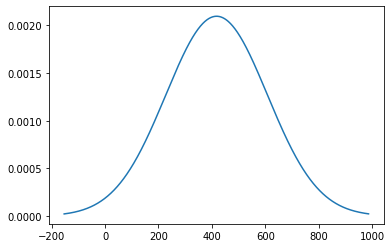

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 44.93
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 790.93
-----
Математическое ожидание: 33.38 ; Стандартное отклонение: 28.23 ; Поле: count_messages ; Тариф: smart


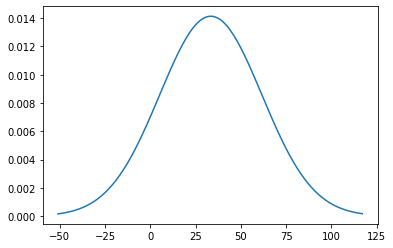

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 0
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 88.71
-----
Математическое ожидание: 16208.39 ; Стандартное отклонение: 5870.48 ; Поле: sum_internet ; Тариф: smart


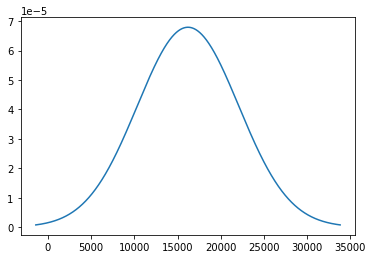

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 4702.46
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 27714.32
-----
Математическое ожидание: 526.62 ; Стандартное отклонение: 317.61 ; Поле: sum_calls ; Тариф: ultra


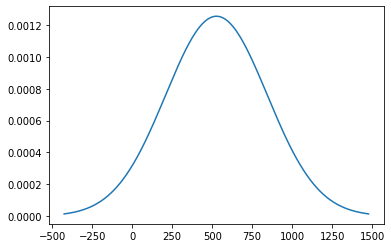

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 0
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 1149.12
-----
Математическое ожидание: 49.36 ; Стандартное отклонение: 47.8 ; Поле: count_messages ; Тариф: ultra


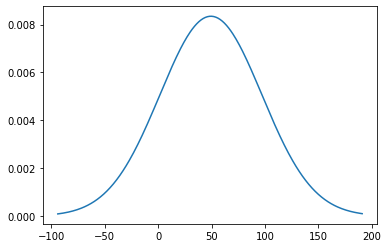

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 0
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 143.05
-----
Математическое ожидание: 19468.81 ; Стандартное отклонение: 10087.17 ; Поле: sum_internet ; Тариф: ultra


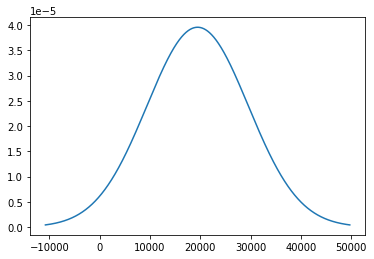

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 0
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 39239.3
-----
sum_calls - ultra


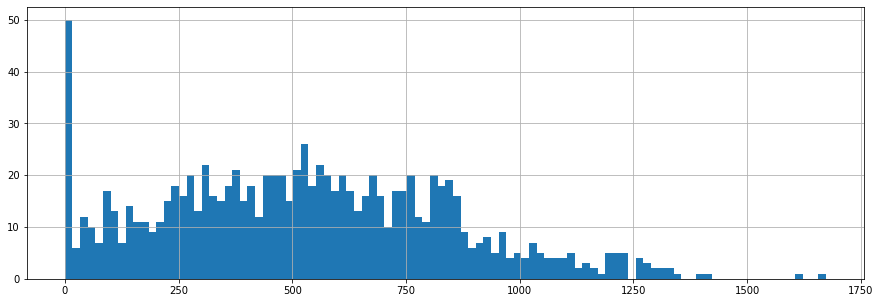

sum_calls - smart


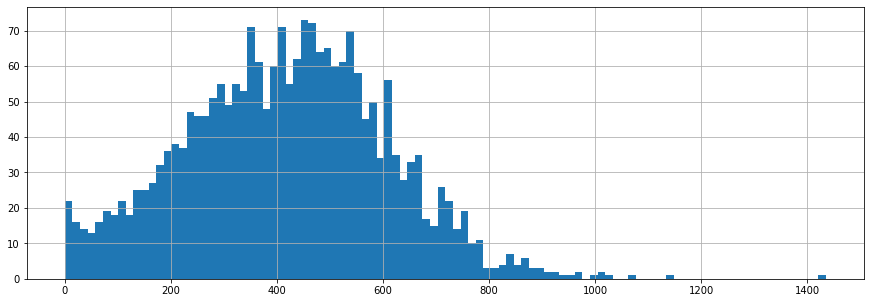

count_messages - ultra


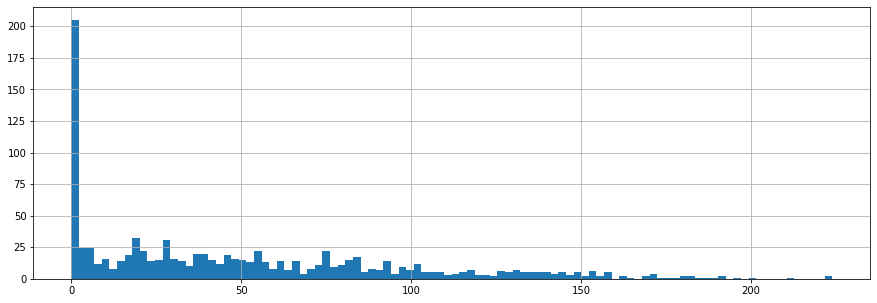

count_messages - smart


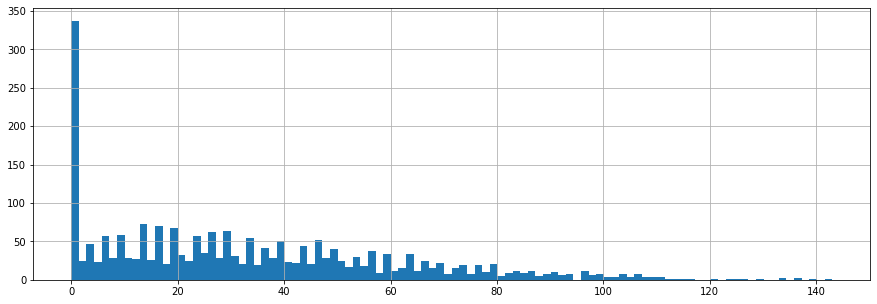

sum_internet - ultra


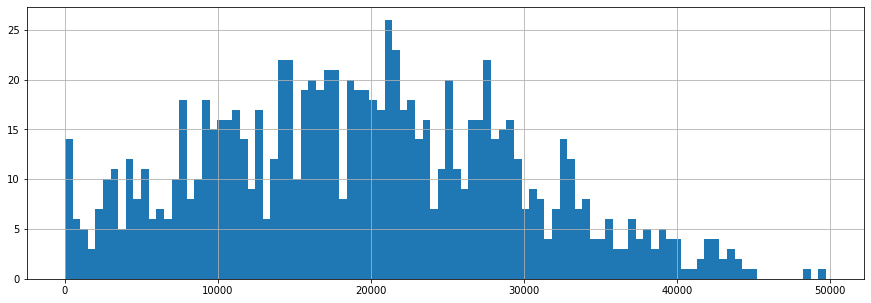

sum_internet - smart


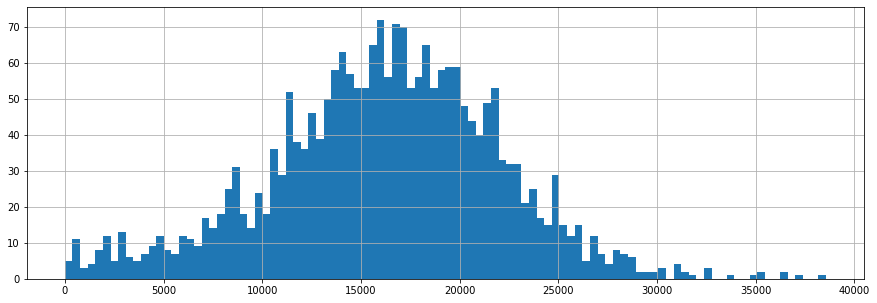

In [46]:
display(df_users[df_users['user_id'].isin(range(1494,1500))])
df_agg_month_test = df_calls_test.groupby(['user_id','month'])['mins'].agg(['sum','count'])
df_agg_month_test = pd.merge(df_agg_month_test, df_messages_test.groupby(['user_id','month'])['id'].agg(['count']), on=['user_id','month'], how='outer', suffixes=('_calls','_messages')).sort_values(['user_id','month'])
df_agg_month_test = pd.merge(df_agg_month_test, df_internet_test.groupby(['user_id','month'])['mb_used'].agg(['sum']), on=['user_id','month'], how='outer', suffixes=('_calls','_internet')).sort_values(['user_id','month'])
display(df_agg_month_test.isna().sum())
df_agg_month_test = df_agg_month_test.fillna(0)
df_agg_month_test = df_agg_month_test.reset_index()
df_agg_month_test = pd.merge(df_agg_month_test, df_users[['user_id','tariff', 'location']], on = 'user_id', how = 'left')
df_agg_month_test = pd.merge(df_agg_month_test, df_tariffs[['tariff_name','minutes_included', 'rub_per_minute', 'messages_included','rub_per_message','mb_per_month_included','rub_per_gb','rub_monthly_fee']], left_on = 'tariff', right_on = 'tariff_name', how = 'left')
df_agg_month_test['calls_cash'] = ((df_agg_month_test['sum_calls'] - df_agg_month_test['minutes_included']).where((df_agg_month_test['sum_calls'] - df_agg_month_test['minutes_included']) > 0, 0) * df_agg_month_test['rub_per_minute']).astype('int')
df_agg_month_test['message_cash'] = ((df_agg_month_test['count_messages'] - df_agg_month_test['messages_included']).where((df_agg_month_test['count_messages'] - df_agg_month_test['messages_included']) > 0, 0) * df_agg_month_test['rub_per_message']).astype('int')
df_agg_month_test['internet_cash'] = ((((df_agg_month_test['sum_internet'] - df_agg_month_test['mb_per_month_included']) / 1024).fillna(0).apply(lambda x: math.ceil(x))).where((df_agg_month_test['sum_internet'] - df_agg_month_test['mb_per_month_included']) > 0, 0) * df_agg_month_test['rub_per_gb']).astype('int')
df_agg_month_test['temp_cash'] = (df_agg_month_test['rub_monthly_fee'].where((df_agg_month_test['sum_calls'] > 0) | (df_agg_month_test['count_messages'] > 0) | (df_agg_month_test['sum_internet'] > 0), 0)).astype('int')
df_agg_month_test['total_cash'] = ((df_agg_month_test['sum_calls'] - df_agg_month_test['minutes_included']).where((df_agg_month_test['sum_calls'] - df_agg_month_test['minutes_included']) > 0, 0) * df_agg_month_test['rub_per_minute'] + (df_agg_month_test['count_messages'] - df_agg_month_test['messages_included']).where((df_agg_month_test['count_messages'] - df_agg_month_test['messages_included']) > 0, 0) * df_agg_month_test['rub_per_message'] + (((df_agg_month_test['sum_internet'] - df_agg_month_test['mb_per_month_included']) / 1024).fillna(0).apply(lambda x: math.ceil(x))).where((df_agg_month_test['sum_internet'] - df_agg_month_test['mb_per_month_included']) > 0, 0) * df_agg_month_test['rub_per_gb'] + df_agg_month_test['rub_monthly_fee'].where((df_agg_month_test['sum_calls'] > 0) | (df_agg_month_test['count_messages'] > 0) | (df_agg_month_test['sum_internet'] > 0), 0)).astype('int')
df_agg_month_test = df_agg_month_test.drop(['tariff_name','minutes_included', 'rub_per_minute', 'messages_included','rub_per_message','mb_per_month_included','rub_per_gb','rub_monthly_fee'],axis = 1)
df_agg_month_test.set_index(['user_id','month'], inplace=True)
print("\033[1m\033[43m {}".format('Помесячный анализ данных до постпроцессинговых операций'),"\033[0m")
display(df_agg_month_test.tail(35))
print("\033[1m\033[43m {}".format('Помесячный анализ данных после постпроцессинговых операций'),"\033[0m")
display(df_agg_month.tail(35))
df_agg_mean_test = pd.DataFrame(round(df_calls_test.groupby('user_id')['mins'].sum() / df_calls_test.groupby('user_id')['month'].unique().apply(lambda x: len(x)), 2))
df_agg_mean_test = pd.merge(df_agg_mean_test, pd.DataFrame(round(df_messages_test.groupby('user_id')['id'].count() / df_messages_test.groupby('user_id')['month'].unique().apply(lambda x: len(x)), 2)), on='user_id', how='outer')
df_agg_mean_test = pd.merge(df_agg_mean_test, pd.DataFrame(round(df_internet_test.groupby('user_id')['mb_used'].sum() / df_internet_test.groupby('user_id')['month'].unique().apply(lambda x: len(x)), 2)), on='user_id', how='outer')
df_agg_mean_test.columns = ['calls','messages','internet']
print("\033[1m\033[43m {}".format('Анализ усредненных значений для каждого клиента до постпроцессинговых операций'),"\033[0m")
display(df_agg_mean_test.sort_values('user_id').tail(6))
print("\033[1m\033[43m {}".format('Анализ усредненных значений для каждого клиента после постпроцессинговых операций'),"\033[0m")
display(df_agg_mean.sort_values('user_id').tail(6))
print("\033[1m\033[43m {}".format('Исследовательский анализ данных в соответствии с требованием, но не корректным решением задачи'),"\033[0m")
df_group_test = round(df_agg_month_test.groupby('tariff')[['sum_calls','count_messages','sum_internet']].agg(['mean','std','var']), 2)
display(df_group_test)
s = 0     
m = 100
for k in range(len(df_group_test)):
    for i,j in df_group_test:
        s = s + 1
        if s % 3 == 2:
            print('Математическое ожидание:', m, '; Стандартное отклонение:', df_group_test[i,j][k], '; Поле:', i, '; Тариф:', df_group_test.index[k])
            plt.plot(range(int(m - 3 * df_group_test[i,j][k]), int(m + 3 * df_group_test[i,j][k])), scipy.stats.norm.pdf(range(int(m - 3 * df_group_test[i,j][k]), int(m + 3 * df_group_test[i,j][k])), m, df_group_test[i,j][k]))
            plt.show()
            print('Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией):', round(scipy.stats.norm(m, df_group_test[i,j][k]).ppf(0.025), 2) if scipy.stats.norm(m, df_group_test[i,j][k]).ppf(0.025) > 0 else 0)
            print('Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией):', round(scipy.stats.norm(m, df_group_test[i,j][k]).ppf(0.975), 2))
            print('-----')
        else:
            m = df_group_test[i,j][k]
        # print(s)
    m=m+1  
for i in df_agg_month_test[['sum_calls','count_messages','sum_internet']]:
    for j in df_agg_month_test['tariff'].unique():
        print(i,'-',j)
        df_agg_month_test[df_agg_month_test['tariff'] == j][i].hist(bins=100, figsize=(15,5))
        plt.show()

## Исследовательский анализ данных

<font color='DarkBlue'> 
📌 Далее нужно описать поведение клиентов оператора, исходя из заданной выборки <br> 
📌 Необходимо выяснить, сколько минут разговора, сообщений и какой объём интернет-трафика в среднем требуется пользователям каждого тарифа в месяц, а также посчитать дисперсию и стандартное отклонение. Представленные описательные параметры рекомендуется определять по усредненному показателю пользователей, не по месяцам, так как у каждого пользлвателя приблизительно однаковые ежемесячные расходы, как было замечено из таблиц выше <br>
</font> 

In [47]:
df_group = round(df_agg_month.groupby('tariff')[['sum_calls','count_messages','sum_internet']].agg(['mean','std','var']), 2)
df_group

sum_calls                       count_messages                      \
              mean     std           var           mean    std          var   
tariff                                                                        
smart   453.000000  176.31  31086.859375      36.150002  28.77   827.849976   
ultra   572.369995  307.87  94780.921875      52.970001  48.99  2400.250000   

        sum_internet                       
                mean      std         var  
tariff                                     
smart   17527.039062  4929.05  24295504.0  
ultra   21141.240234  9533.73  90892008.0

<font color='DarkBlue'> 
📌 Из сводной таблицы заметно, как и предполагалось, что услугами оператора чаще и больше пользуются клиенты, подключившие тариф 'ультра', но не намного. Средние значения не превышают аналогичные у бюджетного тарифа более, чем в 1.5 раза (за исключением наименее прибыльной услуги отправки сообщений), а средние отклонения приблизительно в 2 раза больше <br> 
📌 Для дополнительной оценки отклонений можно описать нормальные распределения разброса значений рассматриваемых параметров, так как анализируются непрерывные количественные величины, используя правило 3 сигм для визуализации распределения <br>
</font> 

Математическое ожидание: 453.0 ; Стандартное отклонение: 176.31 ; Поле: sum_calls ; Тариф: smart


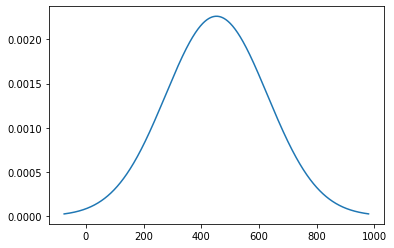

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 107.44
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 798.56
-----
Математическое ожидание: 36.15 ; Стандартное отклонение: 28.77 ; Поле: count_messages ; Тариф: smart


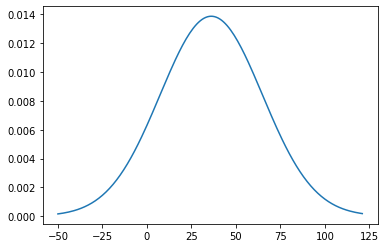

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 0
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 92.54
-----
Математическое ожидание: 17527.04 ; Стандартное отклонение: 4929.05 ; Поле: sum_internet ; Тариф: smart


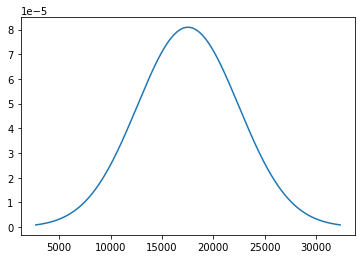

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 7866.28
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 27187.8
-----
Математическое ожидание: 572.37 ; Стандартное отклонение: 307.87 ; Поле: sum_calls ; Тариф: ultra


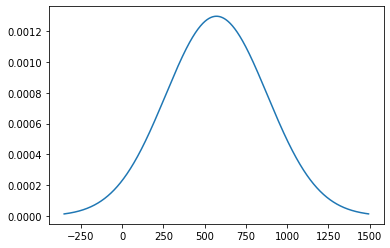

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 0
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 1175.78
-----
Математическое ожидание: 52.97 ; Стандартное отклонение: 48.99 ; Поле: count_messages ; Тариф: ultra


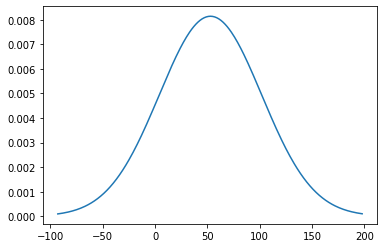

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 0
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 148.99
-----
Математическое ожидание: 21141.24 ; Стандартное отклонение: 9533.73 ; Поле: sum_internet ; Тариф: ultra


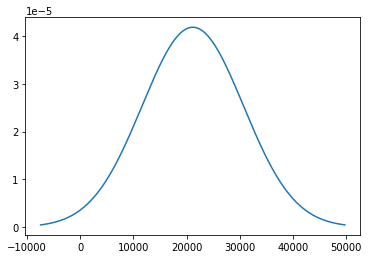

Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 2455.47
Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией): 39827.01
-----


In [48]:
s = 0     
m = 100
for k in range(len(df_group)):
    for i,j in df_group:
        s = s + 1
        if s % 3 == 2:
            print('Математическое ожидание:', m, '; Стандартное отклонение:', df_group[i,j][k], '; Поле:', i, '; Тариф:', df_group.index[k])
            plt.plot(range(int(m - 3 * df_group[i,j][k]), int(m + 3 * df_group[i,j][k])), scipy.stats.norm.pdf(range(int(m - 3 * df_group[i,j][k]), int(m + 3 * df_group[i,j][k])), m, df_group[i,j][k]))
            plt.show()
            print('Минимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией):', round(scipy.stats.norm(m, df_group[i,j][k]).ppf(0.025), 2) if scipy.stats.norm(m, df_group[i,j][k]).ppf(0.025) > 0 else 0)
            print('Максимальное значение при пороговом значении 5% для признания его достоверным (не выбросом и случайной аномалией):', round(scipy.stats.norm(m, df_group[i,j][k]).ppf(0.975), 2))
            print('-----')
        else:
            m = df_group[i,j][k]
        # print(s)
    m=m+1    

<font color='DarkBlue'> 
📌 Исходя из представленных графиков заметно, что разброс значительный по причине разнородности пользователей, где-то даже может быть отрицательным, поэтому даже большое отклонение не является случайным и входит в предсказанный диапазон. В случае сравнения генеральных совокупностей правило вхождения строже в отличие от анализа относительно заданного параметра в связи с наличием неопределенности разброса отклонений <br> 
📌 Для визуального анализа соответствующих значений исходных выборок можно построить гистограммы по каждому из них <br>
</font> 

sum_calls - ultra


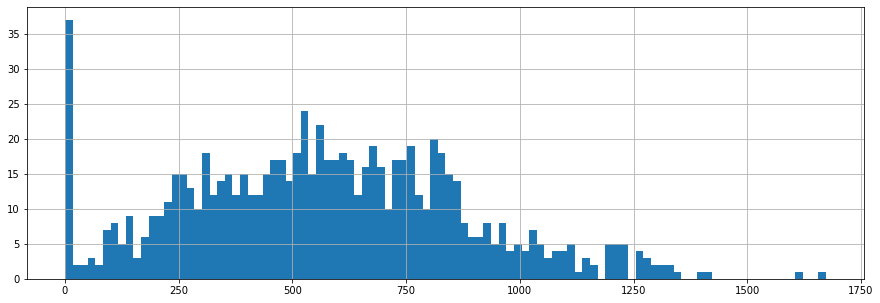

sum_calls - smart


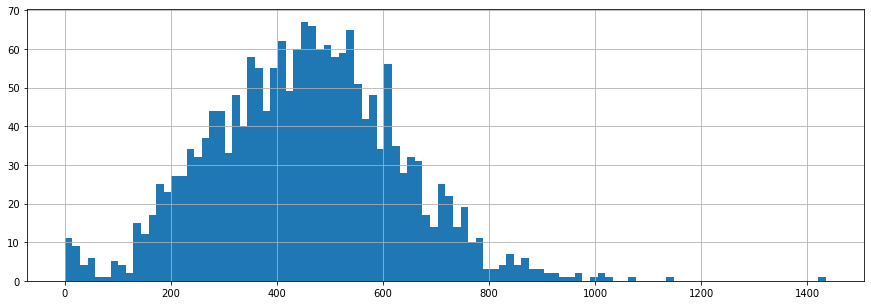

count_messages - ultra


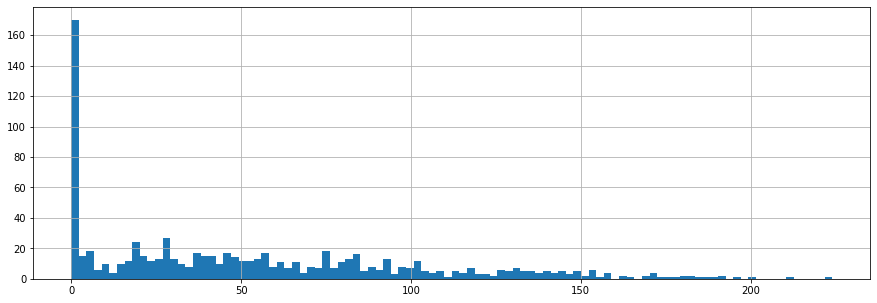

count_messages - smart


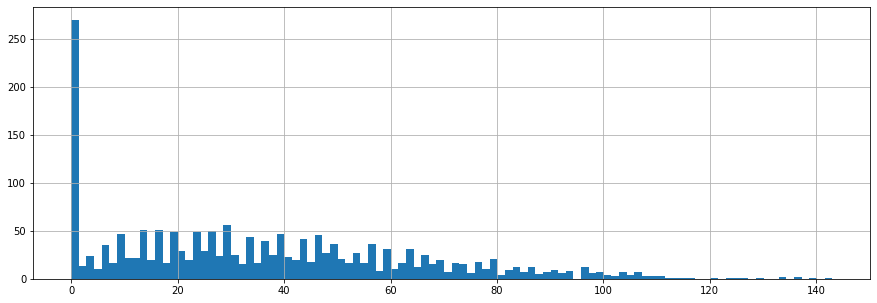

sum_internet - ultra


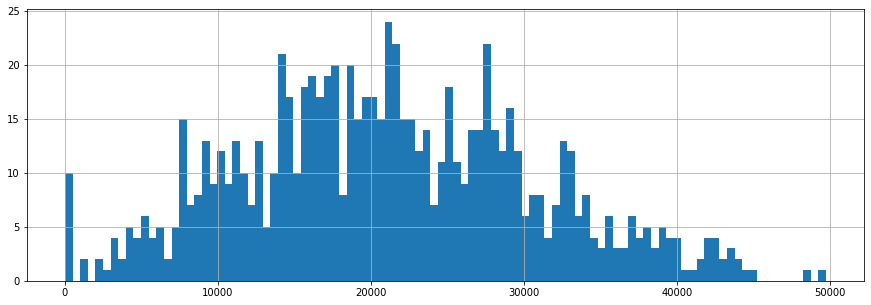

sum_internet - smart


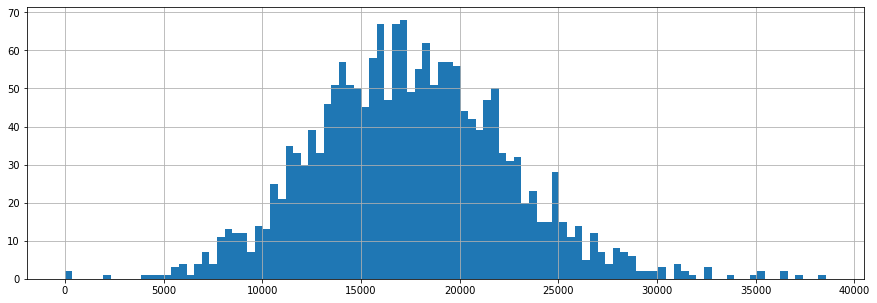

In [49]:
for i in df_agg_month[['sum_calls','count_messages','sum_internet']]:
    for j in df_agg_month['tariff'].unique():
        print(i,'-',j)
        df_agg_month[df_agg_month['tariff'] == j][i].hist(bins=100, figsize=(15,5))
        plt.show()

<font color='DarkBlue'> 
📌 На гистограммах определяется факт о том, что большее количество пользователей тарифа 'smart' использует около 500 минут в месяц, часто выходя за обозначенный лимит. Все пользователи тарифа 'ultra' укладываются в 2000 минут, что значительно меньше лимита, причем значения концентрируются в левой части гистограммы около значения, равного 700 <br> 
📌 Касательно количества используемого пакета сообщений в месяц наблюдается похожая картина: пользователи тарифа 'smart' в большинстве укладываются в лимит, но достаточная их часть превышает входящую в стоимость тарифа норму использования, а пользователи тарифа 'ultra' не используют и пятой части пакета. Можно сделать заключение, что данная функция становится менее популярной в связи с использованием интернет-траффика для подобных целей <br>
📌 Большинство пользователей тарифа 'smart' не укладывается во входящий в стоимость пакета лимит интернет-траффика 15 ГБ, поэтому заметна частая переплата за его использование сверх нормы, основная часть данных концентрируется около значений 15-20 ГБ. Пользователи тарифа 'ultra' чаще укладываются в ограниченный лимит с основной концентрацией в центре гистограммы, но и здесь присутствуют клиенты, превышающие количество допустимого бесплатного траффика <br>    
</font> 

## Проверка гипотез

<font color='DarkBlue'> 
📌 Необходимо проверить гипотезу: средняя выручка пользователей тарифов 'Ультра' и 'Смарт' различаются <br> 
📌 Сначала необходимо сгруппировать агрегированные значения выручки по тарифам (сумма выручки, количество периодов пользования в общем (месяцев), средняя месячная выручка с каждого абонента и стандартное отклонение) <br>   
</font> 

In [50]:
df_total_tariff = round(df_agg_month.groupby('tariff')['total_cash'].agg(['sum','count','mean','std']), 2)
df_total_tariff

,sum,count,mean,std
tariff,,,,
smart,2610945.0,1857,1406.00,829.47
ultra,1721700.0,823,2091.98,406.80


<font color='DarkBlue'> 
📌 Из таблицы можно выявить: количество месяцев коррелируется с количеством клиентов, значит пользователи разных тарифов одинаково распределены по времени подключения и пользования рассматриваемыми услугами в исходной выборке (разница между количеством пользователей рассматриваемых тарифов почти в 2.5 раза) <br> 
📌 Также заметно, что большую прибыль в сумме приносят пользователи тарифа 'smart' даже с учетом того, что эти клиенты часто выходят за рамки лимитов, но разброс их поведения шире и более непредсказуем. Если рассматривать среднего пользователя, наоборот, пользователи тарифа 'ultra' в 1.5 раза выгоднее для компании. То есть, если увеличить премиальный сегмент и нацелить маркетинг на соответствующий контингент, общая выручка скорее будет больше <br>     
📌 Далее можно визуализировать графики нормальных распределений выручки пользователей для каждого тарифа <br>   
</font> 

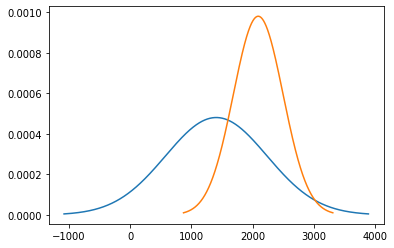

In [51]:
#plt.plot(df_joined[df_joined['tariff_name'] == 'smart']['total_cash'].sort_values(), scipy.stats.norm.pdf(df_joined[df_joined['tariff_name'] == 'smart']['total_cash'].sort_values(), 7438.589744, 5449.981832))
for i in range(len(df_total_tariff)):
    plt.plot(range(int(df_total_tariff['mean'][i] - 3 * df_total_tariff['std'][i]), int(df_total_tariff['mean'][i] + 3 * df_total_tariff['std'][i])),scipy.stats.norm.pdf(range(int(df_total_tariff['mean'][i] - 3 * df_total_tariff['std'][i]), int(df_total_tariff['mean'][i] + 3 * df_total_tariff['std'][i])), df_total_tariff['mean'][i], df_total_tariff['std'][i]))
plt.show()

<font color='DarkBlue'> 
📌 Из графика заметно, что распределения различаются, необходимо проверить альтернативную гипотезу, являющуюся двухсторонней, с помощью сравнения средних двух независимых генеральных совокупностей, относящихся к совершенно разным пользователям. Соответственно, нулевая гипотеза повествует о совпадении рассматриваемых совокупностей. Критичный параметр 'альфа' стандартно можно принять раным 5%, определяющим, что в разброс значений для утверждения нулевой гипотезы не входят области по 2.5% с каждой стороны графика <br> 
</font> 

In [52]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется больше него - можно отвергнуть гипотезу
results = scipy.stats.ttest_ind(df_agg_month[df_agg_month['tariff'] == 'smart']['total_cash'], df_agg_month[df_agg_month['tariff'] == 'ultra']['total_cash'], equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue > alpha:
    print("Отвергается альтернативная гипотеза")
else:
    print("Не получилось отвергнуть альтернативную гипотезу") 

p-значение: 6.338926778702142e-158
Не получилось отвергнуть альтернативную гипотезу


<font color='DarkBlue'> 
📌 Альтернативная гипотеза не отвергнута, соответственно средняя выручка пользователей тарифов 'Ультра' и 'Смарт' различаются. P-value намного меньше 5%, соответственно, даже при очень малом ее значении указанная в задании гипотеза будет верна <br> 
📌 Теперь необходимо проверить следующую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Соответственно, нулевой будет являться обратная: средняя выручка пользователей из Москвы совпадает с выручкой пользователей из других регионов <br>
📌 Как и в предыдущем случае, нужно сгруппировать агрегированные значения выручки по расположению клиентов <br>
</font> 

In [53]:
df_total_location = round(df_agg_month.groupby('location')['total_cash'].agg(['sum','count','mean','std']), 2)
df_total_location

,sum,count,mean,std
location,,,,
other,3505653.0,2177,1610.31,804.93
Москва,826992.0,503,1644.12,734.79


<font color='DarkBlue'> 
📌 В таблице прослеживается похожая зависимость разницы между группами клиентов как по количеству месяцев пользования, так и пользователей в общем (разница между их количеством в соответствующих группах почти в 4 раза), средняя выручка, как и ее стандартное отклонение приблизительно одинаковы <br> 
📌 Далее можно визуализировать графики нормальных распределений выручки пользователей для каждого региона из рассматриваемой выборки по заданной группировке <br>   
</font> 

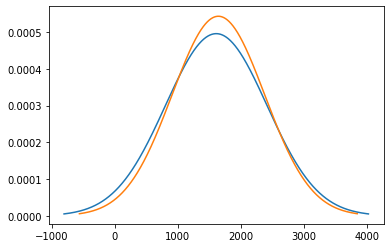

In [54]:
for i in range(len(df_total_location)):
    plt.plot(range(int(df_total_location['mean'][i] - 3 * df_total_location['std'][i]), int(df_total_location['mean'][i] + 3 * df_total_location['std'][i])),scipy.stats.norm.pdf(range(int(df_total_location['mean'][i] - 3 * df_total_location['std'][i]), int(df_total_location['mean'][i] + 3 * df_total_location['std'][i])), df_total_location['mean'][i], df_total_location['std'][i]))
plt.show()

<font color='DarkBlue'> 
📌 На графике явно выражено, что распределения очень похожи. Можно посмотреть на более глубокие распределения полученных выборок по тарифам, также составив сводную таблицу <br> 
</font> 

In [55]:
round(df_agg_month.groupby(['location','tariff'])['total_cash'].agg(['sum','count','mean']), 2)

sum  count     mean
location tariff                           
other    smart   2181903.0   1544  1413.15
         ultra   1323750.0    633  2091.23
Москва   smart    429042.0    313  1370.74
         ultra    397950.0    190  2094.47

<font color='DarkBlue'> 
📌 Из полученных данных можно определить, что пользователей, использующих тариф 'ultra' в Москве немного больше по отношению к другим, чем в остальных регионах, и средняя прибыль с пользователей бюджетного сегмента меньше, а с премиального приблизительно такая же, соответственно, возможно, нужно распространять больше рекламы для разного контингента в различных локациях. Но также необходимо учесть, что средняя выручка распределилась таким образом, так как период пользования тарифами для разных локаций другой, что нивелирует разницу в выручке с пользователей, расположенных в рассматриваемых регионах <br> 
📌 Необходимо проверить альтернативную гипотезу, являющуюся двухсторонней, с помощью сравнения средних двух независимых генеральных совокупностей, относящихся к совершенно разным пользователям. Соответственно, нулевая гипотеза повествует об обратном, совпадении рассматриваемых совокупностей. Критичный параметр 'альфа' стандартно можно принять раным 5%, определяющим, что в разброс значений для утверждения нулевой гипотезы не входят области по 2.5% с каждой стороны графика <br> 
</font> 

In [56]:
results = scipy.stats.ttest_ind(df_agg_month[df_agg_month['location'] == 'Москва']['total_cash'], df_agg_month[df_agg_month['location'] == 'other']['total_cash'], equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue > alpha:
    print("Отвергается альтернативная гипотеза")
else:
    print("Не получилось отвергнуть альтернативную гипотезу") 

p-значение: 0.36151912167590994
Отвергается альтернативная гипотеза


<font color='DarkBlue'> 
📌 Нулевая гипотеза не отвергнута, соответственно средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. P-value достаточно близка к 50%, соответственно, значения совокупностей распределены почти одинаково <br> 
</font> 

## Вывод

<font color='DarkBlue'> 
📌 В ходе осуществленных исследований проведен предварительный анализ тарифов «Мегалайна» и выявлено: <br>     
    - предоставленные данные хорошего качества, не содержатся пропуски и ошибки, за исключением отсутствия траффика в некоторых сессиях пользователей и наличия дублирующего индекс столбца в одном из датасетов. В поле 'id' некоторых исходных таблиц данные, коррелирующиеся с другим столбцом, удалены. Добавлены столбцы с агрегированными значениями параметров, преобразованы типы данных для последующего анализа <br>
    - определены усредненные значения по использованию сервисов, предоставляемых оператором связи, а также выручка с них по месяцам и в общем для каждого пользователя <br>
    - из общих цифр однозначно определить лучший тариф нельзя, но пользователи тарифа 'ultra' приносят больше прибыли, поэтому желательно развивать это направление, также можно оптимизировать значения лимитов для получения большей выручки <br>   
    - проанализированы гипотезы: 'средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются' не отвергнута, 'средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов' отвергнута <br>    
</font> 